In [1]:
import torchani 
import torch 
from torch import nn 
from torch.optim import SGD, Adam 
import torch.nn.functional as F
import random 
from tqdm import tqdm
import numpy as np 
from pyanitools import anidataloader 
# helper function to convert energy unit from Hartree to kcal/mol
from torchani.units import hartree2kcalmol
import math
from sklearn.model_selection import train_test_split

# device to run the training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# define the aev computer object 
Rcr = 5.2
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250])
Rca = 3.5
EtaA = torch.tensor([8], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]) 
Zeta = torch.tensor([32], dtype=torch.float)
species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order)

#should write this in the correct order to run 
aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA,Zeta, ShfA, ShfZ, num_species).to(device)
    
# generate networks for hydrogen, oxygen, nitrogen, and carbon
aev_dim = aev_computer.aev_length

H_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 160),
    torch.nn.CELU(0.1),
    torch.nn.Linear(160, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

C_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 144),
    torch.nn.CELU(0.1),
    torch.nn.Linear(144, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

N_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

O_network = torch.nn.Sequential(
    torch.nn.Linear(aev_dim, 128),
    torch.nn.CELU(0.1),
    torch.nn.Linear(128, 112),
    torch.nn.CELU(0.1),
    torch.nn.Linear(112, 96),
    torch.nn.CELU(0.1),
    torch.nn.Linear(96, 1)
)

In [3]:
# define the ANI model 
class ANIModel(torch.nn.ModuleDict):
    '''
    This class defines the ANI model. It takes in a list of modules, and creates a dictionary of modules.
    The keys of the dictionary are the indices of the modules in the list, and the values are the modules themselves.

    Arguments 
    ---------
    modules: list
        A list of modules.
    '''
    def __init__(self, modules):
        '''
        This function initializes the ANI model. It takes in a list of modules, and creates a dictionary of modules.
        The keys of the dictionary are the indices of the modules in the list, and the values are the modules themselves.

        Arguments 
        ---------
        modules: list
            A list of modules.
        '''
        super().__init__(self)
        # define the modules as an ordered dictionary
        for i, m in enumerate(modules):
            self[str(i)] = m


    def forward(self, species, aevs):
        '''
        This function defines the forward pass of the ANI model. It takes in the species and AEVs, and returns the energy.

        Arguments
        ---------
        species: torch.tensor
            A tensor of species.

        aevs: torch.tensor
            A tensor of AEVs.
        '''
        # flatten the species and aevs
        species_ = species.flatten()
        aev = aevs.flatten(0,1)
        
        # initialize the output 
        output = aev.new_zeros(species_.shape)
        
        # loop through and generate the mask for output calculation 
        for i, m in enumerate(self.values()):
            mask = (species_ == i)
            midx = mask.nonzero().flatten()
            if midx.shape[0] > 0:
                input_ = aev.index_select(0, midx)
                output.masked_scatter_(mask, m(input_).flatten())
        output = output.view_as(species)
        return torch.sum(output, dim=1)

In [4]:
from functools import wraps 
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap

@timing
class Trainer():
    '''
    This class defines the trainer for the ANI model. It takes in the model, optimizer type, learning rate, epochs, batch size, and device.
    ''' 
    def __init__(self, model, optimizer_type, learning_rate, epochs, batch_size, device):
        '''
        This function initializes the trainer for the ANI model. It takes in the model, optimizer type, learning rate, epochs, batch size, and device.

        Arguments
        ---------
        model: torch.nn.Module
            The ANI model.
        
        optimizer_type: str
            The optimizer type. Either Adam or SGD.

        learning_rate: float
            The learning rate.
        
        epochs: int
            The number of epochs.
        
        batch_size: int
            The batch size.
        
        device: torch.device
            The device to run the model on.
        '''
        # define the model, optimizer, learning rate, epochs, batch size, and device
        self.model = model
        if optimizer_type == 'Adam':
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_type == 'SGD':
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.mse = torch.nn.MSELoss()

        # move the model to the device
        self.model.to(device)
        self.mse.to(device)
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)

    def train(self, training_set, l2=False):
        '''
        This function trains the model. It takes in the training set and whether to use L2 regularization.

        Arguments
        ---------
        training_set: list
            A list of tuples of training data. Each tuple contains the species, coordinates, and energies.
        '''
        training_loss = []
        validation_loss = []

        # go through the epochs
        for i in range(self.epochs):
            e_loss = [] 
            e_val_loss = []
            # go through the training set
            for j in range(len(training_set)):

                # initialize the set loss and set validation loss
                set_loss = 0
                set_val_loss = 0
                # get the training data
                train_Xs, train_ys, train_S = training_set[j]
                
                # split further for the validation set
                train_Xs, val_Xs, train_ys, val_ys, train_S, val_S = train_test_split(train_Xs, train_ys, train_S, test_size=0.2, random_state=42)

                # move all training and validation data to the device
                train_Xs = train_Xs.to(device)
                train_ys = train_ys.to(device)
                train_S = train_S.to(device)
                val_Xs = val_Xs.to(device)
                val_ys = val_ys.to(device)
                val_S = val_S.to(device)


                # compute the AEVs for the training and validation set 
                train_aevs = aev_computer((train_S, train_Xs))
                # extract the species and coordinates from train_aevs 
                train_S = train_aevs[0]
                train_aevs = train_aevs[1]
                val_aevs = aev_computer((val_S, val_Xs))
                # extract the species and coordinates from val_aevs
                val_S = val_aevs[0]
                val_aevs = val_aevs[1]

                # create datasets for training and validation set
                train_dataset = torch.utils.data.TensorDataset(train_S, train_aevs, train_ys)
                val_dataset = torch.utils.data.TensorDataset(val_S, val_aevs, val_ys)

                # create dataloaders for training and validation set
                train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
                val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)

                # train the model
                self.model.train()

                for batch in train_dataloader:

                    # get the data and target, as well as the species
                    species, data, target = batch

                    # batch weight 
                    batch_weight = len(species) / len(train_S)

                    # move the data and target to the device
                    species = species.to(device)
                    data = data.to(device)
                    target = target.to(device)

                    # energy pred 
                    energy_pred = self.model(species, data).to(device)

                    loss = self.mse(energy_pred, target)

                    # add L2 regularization
                    if l2:
                        l2_lambda = 0.0001
                        l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
                        loss = loss + l2_lambda * l2_norm


                    # zero the gradients
                    self.optimizer.zero_grad()

                    # backward pass
                    loss.backward()

                    # update the parameters
                    self.optimizer.step()

                    # update the set_loss 
                    set_loss += loss.item() * batch_weight

                # evaluate the model
                self.model.eval()

                for batch in val_dataloader:
                    # get the data and target, as well as the species
                    species, data, target = batch

                    # move the data and target to the device
                    species = species.to(device)
                    data = data.to(device)
                    target = target.to(device)

                    # energy pred 
                    energy_pred = self.model(species, data)

                    loss = self.mse(energy_pred, target)

                    # update the set_val_loss
                    set_val_loss += loss.item() * batch_weight
                
                # update the training and validation loss
                e_loss.append(set_loss)
                e_val_loss.append(set_val_loss)
            
            # average the training and validation loss and calculate the RMSE
            epoch_loss = np.mean(e_loss)
            epoch_val_loss = np.mean(e_val_loss)
            epoch_loss = np.sqrt(epoch_loss) * 627.509
            epoch_val_loss = np.sqrt(epoch_val_loss) * 627.509

            
            # update the training and validation loss
            training_loss.append(epoch_loss)
            validation_loss.append(epoch_val_loss)


            # print the training and validation loss
            # print every 10 epochs
            if i % 10 == 0:
                print('epoch: ', i, 'training loss: ',epoch_loss, 'validation loss: ', epoch_val_loss)

        return training_loss, validation_loss

In [65]:
# load the data and split into training and test set using the file names 
list_of_file_names = ['ani_gdb_s01.h5', 'ani_gdb_s02.h5',
                     'ani_gdb_s03.h5', 'ani_gdb_s04.h5']
training_set = []
testing_set = []
for i in list_of_file_names:
    i = 'ANI-1_release/' + i
    data = anidataloader(i)
    data_iter = data.__iter__()
    for mol in data_iter:
        X = mol['coordinates']
        S = mol['species']
        E = mol['energies']

        # mapping the species to the correct order
        mapping = {'H':0, 'C':1, 'N':2, 'O':3}
        species = np.array([mapping[s] for s in S])
        species = np.tile(species, (X.shape[0], 1))
        species = torch.tensor(species, dtype=torch.long)
        X = torch.tensor(X, dtype=torch.float32)
        E = torch.tensor(E, dtype=torch.float32)

        # split the data into training and testing set
        train_Xs, test_Xs, train_ys, test_ys, train_S, test_S = train_test_split(X, E, species, test_size=0.2, random_state=42)

        # append the training and testing set to the list as a tuple 
        training_set.append((train_Xs, train_ys, train_S))
        testing_set.append((test_Xs, test_ys, test_S))

In [66]:
# create the model
model = ANIModel([H_network, C_network, N_network, O_network])
trainer = Trainer(model, 'Adam', 0.001, 100, 256, device)
training_loss, validation_loss = trainer.train(training_set, l2=True)

epoch:  0 training loss:  [3026.94952955] validation loss:  [2397.89778076]
epoch:  10 training loss:  [3026.94952955 3300.71321551  655.00345869  462.64041123  444.79853655
  805.04885723  430.82446596  264.6876451   256.0349378   260.08704039
  272.15281041] validation loss:  [2397.89778076 1868.18174757  435.46676516  149.06777276  176.64440142
  423.49656343  199.20846031   28.24075816   16.08328572   19.80857523
   58.62450827]
epoch:  20 training loss:  [3026.94952955 3300.71321551  655.00345869  462.64041123  444.79853655
  805.04885723  430.82446596  264.6876451   256.0349378   260.08704039
  272.15281041  257.44229037  274.2720493   306.34926473  269.45256273
  317.59292403  242.83745706  266.56796423  262.53333584  395.63750817
  244.89168933] validation loss:  [2397.89778076 1868.18174757  435.46676516  149.06777276  176.64440142
  423.49656343  199.20846031   28.24075816   16.08328572   19.80857523
   58.62450827   23.45174341   12.21188792   58.80356648   23.04655142
  128

epoch:  80 training loss:  [3026.94952955 3300.71321551  655.00345869  462.64041123  444.79853655
  805.04885723  430.82446596  264.6876451   256.0349378   260.08704039
  272.15281041  257.44229037  274.2720493   306.34926473  269.45256273
  317.59292403  242.83745706  266.56796423  262.53333584  395.63750817
  244.89168933  260.36154084  293.17063753  255.10676671  277.49131648
  327.89094705  381.8381765   377.71081693  670.98964946  251.51308698
  281.84951087  256.81659897  270.67429446  346.11396158  264.70210781
  321.60713524  324.05736021  267.31874996  258.31147806  330.00599458
  257.3786367   273.9570037   257.99508733  462.40684997  331.34717391
  352.37871426  300.50488261  484.27894911  249.31994476  338.75875413
  336.80176341  266.6586737   399.60403228  335.29717218  278.83808974
  328.57798894  379.8081143   416.39995248  251.73708731  300.73219348
  369.28732616  283.07460568  439.06745356  259.9838874   702.79859959
  253.16889147  279.98452321  454.74289486  246.13

In [80]:
# save the model
torch.save(model.state_dict(), 'model.pt')

# run the test set on gpu 
test_loss = []
for i in range(len(testing_set)):
    # get the test data
    test_Xs, test_ys, test_S = testing_set[i]

    # move all test data to the device
    test_Xs = test_Xs.to(device)
    test_ys = test_ys.to(device)
    test_S = test_S.to(device)

    # compute the AEVs for the test set 
    test_aevs = aev_computer((test_S, test_Xs))
    # extract the species and coordinates from test_aevs 
    test_S = test_aevs[0]
    test_aevs = test_aevs[1]

    # create datasets for test set
    test_dataset = torch.utils.data.TensorDataset(test_S, test_aevs, test_ys)

    # create dataloaders for test set
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

    for batch in test_dataloader:
        # get the data and target, as well as the species
        species, data, target = batch

        # move the data and target to the device
        species = species.to(device)
        data = data.to(device)
        target = target.to(device)

        # energy pred 
        energy_pred = model(species, data)

        loss = trainer.mse(energy_pred, target)

        # update the test_loss 
        test_loss.append(loss.item())

In [81]:
test = np.sqrt(test_loss) * 627.509

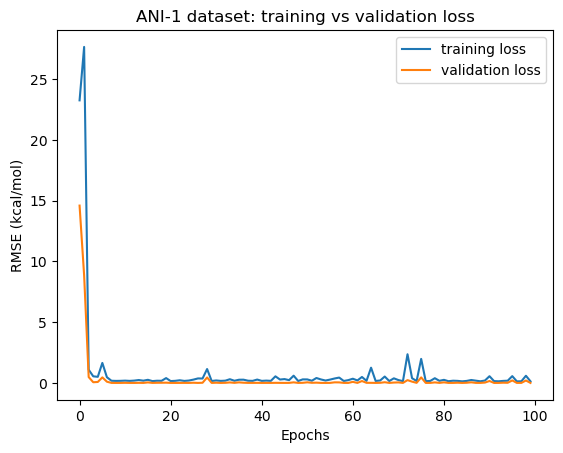

In [84]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.title("ANI-1 dataset: training vs validation loss")
plt.xlabel("Epochs")
plt.ylabel("RMSE (kcal/mol)")
plt.legend()
plt.show()

In [5]:
# load the data and split into training and test set using the file names 
list_of_file_names = ['ani_gdb_s01.h5', 'ani_gdb_s02.h5', 
                     'ani_gdb_s03.h5', 'ani_gdb_s04.h5']

training_set = []
testing_set = []
for i in list_of_file_names:
    i = 'ANI-1_release/' + i
    data = anidataloader(i)
    data_iter = data.__iter__()
    for mol in data_iter:
        X = mol['coordinates']
        S = mol['species']
        E = mol['energies']

        # mapping the species to the correct order
        mapping = {'H':0, 'C':1, 'N':2, 'O':3}
        species = np.array([mapping[s] for s in S])
        species = np.tile(species, (X.shape[0], 1))
        species = torch.tensor(species, dtype=torch.long)
        X = torch.tensor(X, dtype=torch.float32)
        E = torch.tensor(E, dtype=torch.float32)

        # split the data into training and testing set
        train_Xs, test_Xs, train_ys, test_ys, train_S, test_S = train_test_split(X, E, species, test_size=0.2, random_state=42)

        # append the training and testing set to the list as a tuple 
        training_set.append((train_Xs, train_ys, train_S))
        testing_set.append((test_Xs, test_ys, test_S))

In [41]:
# create the model
model = ANIModel([H_network, C_network, N_network, O_network])
trainer = Trainer(model, 'Adam', 0.001, 100, 32, device)
training_loss, validation_loss = trainer.train(training_set, l2=True)

func:'Trainer' args:[(ANIModel(
  (0): Sequential(
    (0): Linear(in_features=384, out_features=160, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=160, out_features=128, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=128, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=384, out_features=144, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=144, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=128, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (

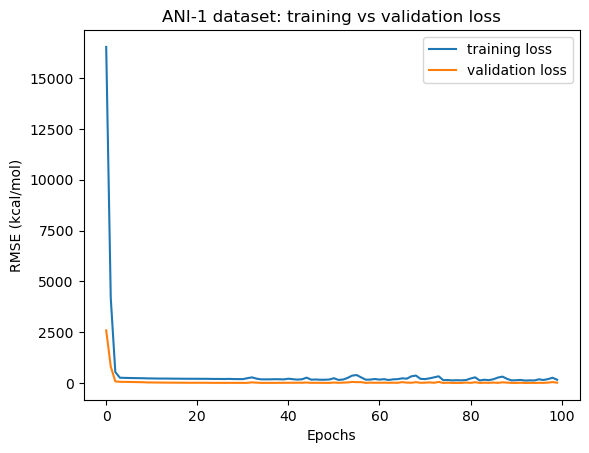

In [42]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.title("ANI-1 dataset: training vs validation loss")
plt.xlabel("Epochs")
plt.ylabel("RMSE (kcal/mol)")
plt.legend()
plt.show()

In [6]:
# create the model
model = ANIModel([H_network, C_network, N_network, O_network])
trainer = Trainer(model, 'Adam', 0.001, 100, 256, device)
training_loss, validation_loss = trainer.train(training_set, l2=True)

func:'Trainer' args:[(ANIModel(
  (0): Sequential(
    (0): Linear(in_features=384, out_features=160, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=160, out_features=128, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=128, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=384, out_features=144, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=144, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=128, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (

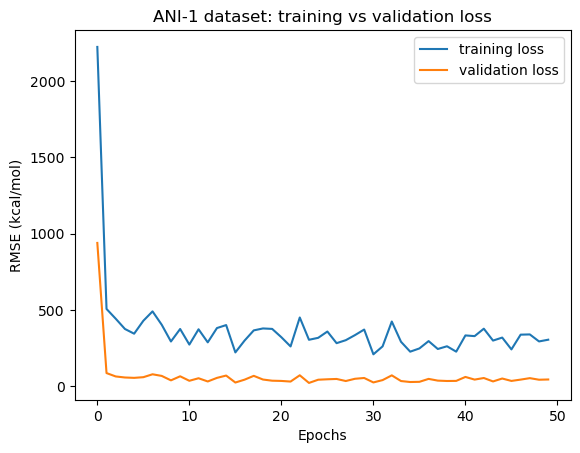

In [10]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.title("ANI-1 dataset: training vs validation loss")
plt.xlabel("Epochs")
plt.ylabel("RMSE (kcal/mol)")
plt.legend()
plt.show()

In [8]:
# create the model
model = ANIModel([H_network, C_network, N_network, O_network])
trainer = Trainer(model, 'Adam', 0.001, 50, 128, device)
training_loss, validation_loss = trainer.train(training_set, l2=True)

func:'Trainer' args:[(ANIModel(
  (0): Sequential(
    (0): Linear(in_features=384, out_features=160, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=160, out_features=128, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=128, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (1): Sequential(
    (0): Linear(in_features=384, out_features=144, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=144, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (6): Linear(in_features=96, out_features=1, bias=True)
  )
  (2): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): CELU(alpha=0.1)
    (2): Linear(in_features=128, out_features=112, bias=True)
    (3): CELU(alpha=0.1)
    (4): Linear(in_features=112, out_features=96, bias=True)
    (5): CELU(alpha=0.1)
    (

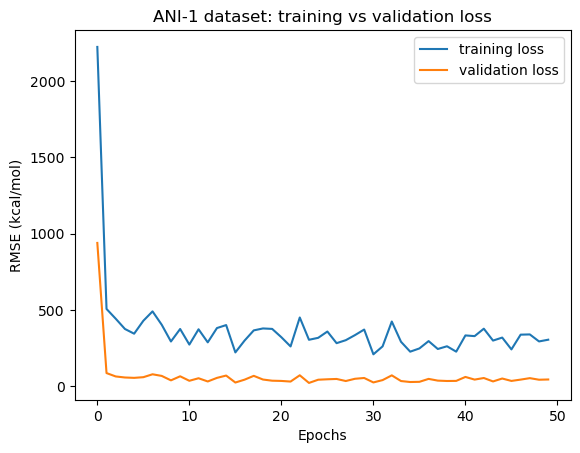

In [9]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.title("ANI-1 dataset: training vs validation loss")
plt.xlabel("Epochs")
plt.ylabel("RMSE (kcal/mol)")
plt.legend()
plt.show()

In [11]:
# save the model
torch.save(model.state_dict(), 'model.pt')

# run the test set on gpu 
test_loss = []
for i in range(len(testing_set)):
    # get the test data
    test_Xs, test_ys, test_S = testing_set[i]

    # move all test data to the device
    test_Xs = test_Xs.to(device)
    test_ys = test_ys.to(device)
    test_S = test_S.to(device)

    # compute the AEVs for the test set 
    test_aevs = aev_computer((test_S, test_Xs))
    # extract the species and coordinates from test_aevs 
    test_S = test_aevs[0]
    test_aevs = test_aevs[1]

    # create datasets for test set
    test_dataset = torch.utils.data.TensorDataset(test_S, test_aevs, test_ys)

    # create dataloaders for test set
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

    for batch in test_dataloader:
        # get the data and target, as well as the species
        species, data, target = batch

        # move the data and target to the device
        species = species.to(device)
        data = data.to(device)
        target = target.to(device)

        # energy pred 
        energy_pred = model(species, data)

        loss = trainer.mse(energy_pred, target)

        # update the test_loss 
        test_loss.append(loss.item())